-------------------------------------------------------------------

- **Name:** Renato Andrade Mosqueira Furtado
- **e-mail:** renato.andrade@engenharia.ufjf.br
- **Objective:** formulate an optimization problem in order to estimate the water inflow for any hydroelectric plant which are considered in the NEWAVE deck.

-------------------------------------------------------------------

# **Install PySDDP**

In [ ]:
!pip install PySDDP

In [ ]:
!pip uninstall PySDDP

# **Import data and libraries**

- Reading the data deck available on the CCEE website in the folder allocated on the user's drive. Therefore, you must change the **PATH** variable by entering the access address to the folder.

In [ ]:
from google.colab import drive
import os
import sys
from google.colab import files


drive.mount('/content/gdrive')

sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/Planejamento Energético')

print(os.getcwd())


#============== User must change here according to the folder used on the drive ================
Caminho = '/content/gdrive/MyDrive/Colab Notebooks/Planejamento Energético/Deck_MAR_2024'
#=================================================================================================

sys.path

Mounted at /content/gdrive
/content


['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/gdrive/MyDrive/Colab Notebooks/Planejamento Energético']

In [ ]:
from PySDDP.Pen import Newave
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from cvxopt import matrix,solvers
import time
import pickle
from sklearn.preprocessing import StandardScaler,normalize
import copy

In [ ]:
casoestudo = Newave(Caminho)

OK! Leitura do CASO.DAT realizada com sucesso.
OK! Leitura do ARQUIVOS.DAT realizada com sucesso.
OK! Leitura do DGER.DAT realizada com sucesso.
OK! Leitura do HIDR.DAT realizada com sucesso.
OK! Leitura do VAZOES.DAT realizada com sucesso.
OK! Leitura do MODIF.DAT realizada com sucesso. ( 101 Usinas Hidraulicas Modificadas )
OK! Leitura do EXPH.DAT realizada com sucesso. ( 1 Usinas Hidraulicas Expandidas )
OK! Leitura do CONFHD.DAT realizada com sucesso.
OK! Leitura do REE.DAT realizada com sucesso. ( 12 Reservatórios Equivalentes de Energia Foram Lidos )
OK! Leitura do SISTEMA.DAT realizada com sucesso.


# **Motivation**

In [ ]:
codigo_uhe = sorted(list(casoestudo.confhd.lista_uhes()))

In [ ]:
potencia = []
nome_uhe = []

for cod in codigo_uhe:

  usina = casoestudo.confhd.get(cod)

  nome_uhe.append(usina['nome'])

  potencia.append(np.max(usina['potencia_tempo']))

In [ ]:
potencia_decrescente = sorted(potencia,reverse=True)
cod = []

for i in range(0,10):

  cod.append(codigo_uhe[potencia.index(potencia_decrescente[i])])

In [ ]:
nome = [casoestudo.confhd.get(codigo)['nome'] for codigo in cod]

for n in nome:

  endereco = nome.index(n)

  len_str = len(n)

  for istr in range(0,len_str):

    if n[istr]==' ' and n[istr-1]==' ' and istr!=0:

      n = n[0:istr-1]

      nome[endereco] = n

      break

    elif istr==len_str-1 and n[istr]==' ':

      n = n[0:istr]

      nome[endereco] = n

      break

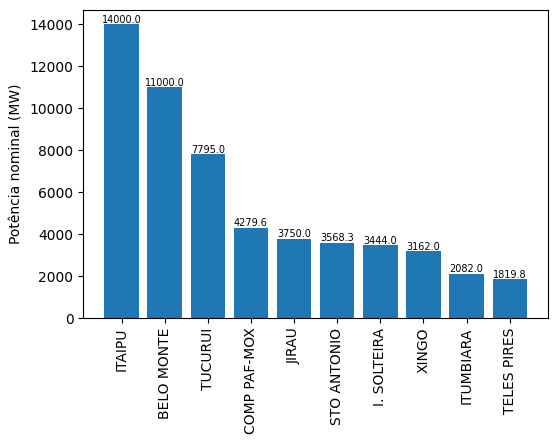

In [ ]:
fig,axis = plt.subplots(figsize=(6,4))

potencia_decrescente_10 = [round(potencia_decrescente[i],2) for i in range(0,10)]

axis.bar(nome,potencia_decrescente_10,color='blue')
plt.xticks(rotation=90,fontsize=10);
axis.bar_label(axis.bar(nome,potencia_decrescente_10),labels=potencia_decrescente_10,fontsize=7.0);
axis.set_ylabel('Rated Power (MW)');

# **Arithmetic Optimization Algorithm**

 - **Adittional material about Arithmetic Optimization Algorithm**:
  - https://ieeexplore.ieee.org/abstract/document/10006248
  - https://www.sba.org.br/cba2022/wp-content/uploads/artigos_cba2022/paper_9772.pdf

 - **Parameteres of the function *AOA*:**
- *funcao_objetivo:* string. If "COSTS", it will optimize the annual optimal costs of the objective function. If "COEFFICIENTS", optimizes the annual coefficients to minimize the sum of errors;
  - *mu:* parameter for updating meta-heuristic variables;
  - *alpha:* parameter used indirectly to update variables in the meta-heuristic. Associated with the **OMP** parameter defined in the function;
  - *epsilon:* small number to avoid division by zero in updates;
  - *N_iter:* total number of iterations;
  - *N_solucoes:* number of possible solutions/individuals for the problem;
  - *AOM_min:* lower limit of the AOM parameter that is used to define the search space;
  - *AOM_max:* upper limit of the AOM parameter that is used to define the search space;
  - *Nome_usina:* string related to the name of the plant;
  - *Ordem:* order used to calculate the estimated flow;
  -*Mes_Estimado:* string variable related to the month in which you want to estimate the variables;
  - *Ano_inicial:* year from which the flows are known and which will be used as an equality equation;
  -*Ano_final:* last year in which all flows are known and which will be used as an equality equation;
  - *SOL_inicial:* initial kick for the meta-heuristic. If there is no initial guess, this variable must receive the value -1. On the other hand, knowing an initial solution, you must start it with a list whose total number of elements is equal to the *Order* variable.
  - *grafico:* if **True** plots convergence graph; if **False**, the graph is not plotted.

## Function

In [ ]:
def AOA(funcao_objetivo,mu,alpha,epsilon,N_iter,N_solucoes,AOM_min,AOM_max,Nome_usina,Ordem,Mes_estimado,Ano_inicial,Ano_final,SOL_inicial,grafico,flag_progresso):

  #------------------ Dados de entrada ----------------------

  Nome_usina = Nome_usina
  Ordem = Ordem
  Mes_estimado = Mes_estimado
  Ano_inicial = Ano_inicial
  Ano_final = Ano_final
  funcao_objetivo = funcao_objetivo

  Nr_anos = Ano_final - Ano_inicial + 1

  # PARÂMETROS DA METAHEURÍSTICA
  mu = mu
  alpha = alpha
  N_iter = N_iter
  N_solucoes = N_solucoes
  AOM_min = AOM_min
  AOM_max = AOM_max
  grafico = grafico
  flag_progresso = flag_progresso

  # SOLUÇÃO INICIAL

  SOL_inicial = SOL_inicial

  #---------------- Leitura da usina selecionada ------------

  uhe = casoestudo.confhd.get(Nome_usina) # Nome_usina -> entrada pelo usuário

  vazoes = np.array(uhe['vazoes'],dtype=float) # Acessa as vazões da usina em questão

  data_vazoes = pd.DataFrame(data=vazoes,columns=['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro'],index = np.linspace(int(1931),int(np.size(vazoes,0)+1931-1),np.size(vazoes,0)))
  # Transforma em DataFrame no qual as colunas são os meses e as linhas os anos: 1931 - 2023

  #--------------- Criação de uma lista com meses -----------------------------

  mes_lista = ['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro']

  #--------------- Desvio padrão e média de todas as vazões do mês selecionado ---------

  desvio = np.std(data_vazoes.loc[Ano_inicial:Ano_final,Mes_estimado])
  media = np.mean(data_vazoes.loc[Ano_inicial:Ano_final,Mes_estimado])

  #--------------------------- Número do mês estimado ----------------------------------

  for k in range(0,len(mes_lista)):
    if mes_lista[k]==Mes_estimado:
      Nr_mes_estimado = k+1

  #=============================================================================================================
  #=========================== ÍNICIO DA OTIMIZAÇÃO ARITMÉTICA =================================================
  #=============================================================================================================

  # FUNÇÃO OBJETIVO = CUSTOS

  if funcao_objetivo=='CUSTOS':

    x_min = 0.0*np.ones((1,Nr_anos)) # valor mínimo das variáveis
    x_max = 10*np.ones((1,Nr_anos)) # valor máximo das variáveis

    N_variaveis = np.size(x_min,1) # número de colunas = número de variáveis

    iter = 0 # contador de iteracoes

    x_inicial = np.zeros((N_solucoes,N_variaveis))

    if SOL_inicial==-1:

      for i in range(0,np.size(x_inicial,0)):
        for j in range(0,np.size(x_inicial,1)):
            x_inicial[i][j] = np.random.uniform(x_min[0][j],x_max[0][j]) # chute inicial para os parâmetros

    else: # chute inicial baseado em alguma saída pré-calculada

      for i in range(0,np.size(x_inicial,0)):
        for j in range(0,np.size(x_inicial,1)):
            x_inicial[i][j] = SOL_inicial[j]*(1 + (0/10))# chute inicial para os parâmetros

    x_sol = x_inicial.copy()
    x_sol_new = np.zeros((N_solucoes,N_variaveis))
    FOB = np.zeros((np.size(x_sol,0),1))
    FOB_new = np.zeros((np.size(x_sol,0),1))

    #---------------------- Inicialização da Função Objetivo -------------------------------

    for i in range(0,np.size(x_sol,0)):

      solucao = parametros_vazao(Nome_usina = Nome_usina, Ordem=Ordem, Mes_estimado = Mes_estimado, Ano_inicial = Ano_inicial,
                                Ano_final=Ano_final, ano_excluido = [], define_pesos=list(x_sol[i,0:np.size(x_sol,1)]), flag_progresso = False)

      #FOB[i][0] = float(solucao[2]) # valor da função objetivo
      FOB[i][0] = float(np.sum(np.abs(solucao[1]['Erro (m3/s)'])))  # valor do somatório dos erros (módulo)

      #----------------------------------------------------------------------------------------

      if i==0:
        Best = FOB[i][0]
        linha = i
      elif FOB[i][0]<=Best:
        Best = FOB[i][0]
        linha = i

    #----------------- Vetores para visualização da convergência -------------------

    x_label = np.zeros((1,N_iter+1))
    y_label = np.zeros((1,N_iter+1))

    #----------------- Inicialização dos vetores para plot -------------------------

    x_label[0][iter] = iter
    y_label[0][iter] = Best

    #====================================================================================================
    #====================================================================================================
    #==================================== PROCESSO ITERATIVO ============================================
    #====================================================================================================
    #====================================================================================================

    while iter<N_iter:

      iter = iter + 1

      AOM = AOM_max + (iter*(AOM_max - AOM_min)/N_iter) # Acelerador de Otimização Matemático
      OMP = 1 - ((iter**(1/alpha))/(N_iter**(1/alpha))) # Otimizador Matemático de Probabilidade

      x_best = x_sol[linha] # xbest = coeficientes/pesos ótimos da função objetivo quadrática

      for i in range(0,np.size(x_sol,0)):

        r1 = np.random.rand(1,np.size(x_sol,1)) # valor randômico do processo
        r2 = np.random.rand(1,np.size(x_sol,1)) # valor randômico do processo
        r3 = np.random.rand(1,np.size(x_sol,1)) # valor randômico do processo

        for j in range(0,np.size(x_sol,1)):
          #------------------------------ ESPAÇO DE BUSCA GLOBAL ---------------------------
          if r1[0][j]>AOM:
            if r2[0][j]>0.5:
              x_sol_new[i][j] = x_best[j]*OMP*((x_max[0][j] - x_min[0][j])*mu + x_min[0][j])
            else:
              x_sol_new[i][j] = x_best[j]/OMP*((x_max[0][j] - x_min[0][j])*mu + x_min[0][j])
          #------------------------------ ESPAÇO DE BUSCA LOCAL ---------------------------
          else:
            if r3[0][j]>0.5:
              x_sol_new[i][j] = x_best[j]+OMP*((x_max[0][j] - x_min[0][j])*mu + x_min[0][j])
            else:
              x_sol_new[i][j] = x_best[j]-OMP*((x_max[0][j] - x_min[0][j])*mu + x_min[0][j])

          #------------------------------ Penalizações ---------------------------

          if x_sol_new[i][j]>x_max[0][j]:
            x_sol_new[i][j] = x_max[0][j]
          elif x_sol_new[i][j]<x_min[0][j]:
            x_sol_new[i][j] = x_min[0][j]

        #-------------------------------- Cálculo da FOB para cada solução atualizada --------------------------

        solucao = parametros_vazao(Nome_usina = Nome_usina, Ordem=Ordem, Mes_estimado = Mes_estimado, Ano_inicial = Ano_inicial,
                                    Ano_final=Ano_final, ano_excluido = [],define_pesos=list(x_sol_new[i,0:np.size(x_sol_new,1)]), flag_progresso=False)

        #FOB_new[i][0] = float(solucao[2])
        FOB_new[i][0] = float(np.sum(np.abs(solucao[1]['Erro (m3/s)'])))  # valor do somatório dos erros (módulo)

        #----------------------------------------------------------------------------------------

        if FOB_new[i][0]<FOB[i][0]:
          x_sol[i] = x_sol_new[i]
          FOB[i][0] = FOB_new[i][0]

      #-------------------------------- Determinação da melhor solução na iteração atual ----------------------

      for s in range(0,np.size(FOB,0)):
        if FOB[s][0]<Best:
          Best = FOB[s][0]
          linha = s

      x_label[0][iter] = iter
      y_label[0][iter] = Best

      if flag_progresso:
        print(f'Best(iter = {iter}) = {Best}')

    #======================================= FIM DO PROCESSO ITERATIVO ==================================================

    if grafico:

      fig = go.Figure()
      fig.add_trace(go.Scatter(x = x_label[0,1:np.size(x_label,1)], y = y_label[0,1:np.size(y_label,1)],mode = 'lines+markers',line=dict(color='blue',width=3)))
      fig.update_layout(title='Convergência do Algoritmo de Otimização Aritmética',
                  xaxis_title = 'Iteração',
                  yaxis_title = 'FOB ((m3/s)^2)',
                  plot_bgcolor='white'
                      )

      fig.update_xaxes(range=[1,N_iter],showgrid=True,showline=True,gridcolor='lightgray',linecolor='black')
      fig.update_yaxes(showgrid=True,showline=True,gridcolor='lightgray',linecolor='black')

      fig.show()



    # Coeficientes

    solucao_otima = parametros_vazao(Nome_usina = Nome_usina, Ordem=Ordem, Mes_estimado = Mes_estimado, Ano_inicial = Ano_inicial,
                                Ano_final=Ano_final, ano_excluido = [],define_pesos=list(x_best),flag_progresso=False)

    coeficientes = solucao_otima[0]
    comparacao = solucao_otima[1]

    penalizacoes = list(x_best)

    anos = [ano for ano in range(Ano_inicial,Ano_final+1)]

    data_custo = pd.DataFrame(data = np.transpose([penalizacoes]),columns=['Custo FOB'],index=anos)

    return coeficientes,data_custo,comparacao

#xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

  elif funcao_objetivo=='COEFICIENTES':

    x_min = -10*np.ones((1,Ordem)) # valor mínimo das variáveis
    x_max = 10*np.ones((1,Ordem)) # valor máximo das variáveis

    N_variaveis = np.size(x_min,1) # número de colunas = número de variáveis

    iter = 0 # contador de iteracoes

    x_inicial = np.zeros((N_solucoes,N_variaveis))

    if SOL_inicial==-1:

      for i in range(0,np.size(x_inicial,0)):
        for j in range(0,np.size(x_inicial,1)):
            x_inicial[i][j] = np.random.uniform(-1,1) # chute inicial para os parâmetros

    else: # chute inicial baseado em alguma saída pré-calculada

      for i in range(0,np.size(x_inicial,0)):
        for j in range(0,np.size(x_inicial,1)):
            x_inicial[i][j] = SOL_inicial[j]*(1 + (np.random.randn()/10))# chute inicial para os parâmetros



    x_sol = x_inicial.copy()
    x_sol_new = np.zeros((N_solucoes,N_variaveis))
    FOB = np.zeros((np.size(x_sol,0),1))
    FOB_new = np.zeros((np.size(x_sol,0),1))

    #-------------------- Montando a matriz de Vazões -------------------------

    A_vaz = np.zeros((Nr_anos,Ordem))

    for linha in range(0,Nr_anos):

      ano = Ano_inicial + linha # acessar o DataFrame

      coluna = 0

      for ord in range(Nr_mes_estimado - Ordem - 1,Nr_mes_estimado-1):

        if ord<0:

          ano_anterior = ano - 1

          mes_ano_anterior = 13 + ord

          A_vaz[linha][coluna] = float(data_vazoes[mes_lista[mes_ano_anterior-1]][ano_anterior])

          coluna = coluna + 1

        else:

          A_vaz[linha][coluna] = float(data_vazoes[mes_lista[ord]][ano])

          coluna = coluna + 1

    #---------------------- Vetor coluna das vazões do mês estimado ------------------------

    Vaz_mes_estimado = data_vazoes.loc[Ano_inicial:Ano_final,Mes_estimado]

    #---------------------- Inicialização da Função Objetivo -------------------------------

    for i in range(0,np.size(x_sol,0)):

      Vaz_estimada = np.dot(A_vaz,np.transpose(x_sol[i,0:Ordem]))

      Erro = np.subtract(Vaz_mes_estimado,Vaz_estimada)

      #Somatorio_erros = float(np.sum(np.square(Erro)))

      Somatorio_erros = float(np.std(Erro))

      FOB[i][0] = Somatorio_erros

      #----------------------------------------------------------------------------------------

      if i==0:
        Best = FOB[i][0]
        linha = i
      elif FOB[i][0]<=Best:
        Best = FOB[i][0]
        linha = i

    #----------------- Vetores para visualização da convergência -------------------

    x_label = np.zeros((1,N_iter+1))
    y_label = np.zeros((1,N_iter+1))

    #----------------- Inicialização dos vetores para plot -------------------------

    x_label[0][iter] = iter
    y_label[0][iter] = Best

    #====================================================================================================
    #====================================================================================================
    #==================================== PROCESSO ITERATIVO ============================================
    #====================================================================================================
    #====================================================================================================

    while iter<N_iter:

      iter = iter + 1

      AOM = AOM_max + (iter*(AOM_max - AOM_min)/N_iter) # Acelerador de Otimização Matemático
      OMP = 1 - ((iter**(1/alpha))/(N_iter**(1/alpha))) # Otimizador Matemático de Probabilidade

      x_best = x_sol[linha]

      for i in range(0,np.size(x_sol,0)):

        r1 = np.random.rand(1,np.size(x_sol,1)) # valor randômico do processo
        r2 = np.random.rand(1,np.size(x_sol,1)) # valor randômico do processo
        r3 = np.random.rand(1,np.size(x_sol,1)) # valor randômico do processo

        for j in range(0,np.size(x_sol,1)):
          #------------------------------ ESPAÇO DE BUSCA GLOBAL ---------------------------
          if r1[0][j]>AOM:
            if r2[0][j]>0.5:
              x_sol_new[i][j] = x_best[j]*OMP*((x_max[0][j] - x_min[0][j])*mu + x_min[0][j])
            else:
              x_sol_new[i][j] = x_best[j]/OMP*((x_max[0][j] - x_min[0][j])*mu + x_min[0][j])
          #------------------------------ ESPAÇO DE BUSCA LOCAL ---------------------------
          else:
            if r3[0][j]>0.5:
              x_sol_new[i][j] = x_best[j]+OMP*((x_max[0][j] - x_min[0][j])*mu + x_min[0][j])
            else:
              x_sol_new[i][j] = x_best[j]-OMP*((x_max[0][j] - x_min[0][j])*mu + x_min[0][j])

          #------------------------------ Penalizações ---------------------------

          if x_sol_new[i][j]>x_max[0][j]:
            x_sol_new[i][j] = x_best[j]
          elif x_sol_new[i][j]<x_min[0][j]:
            x_sol_new[i][j] = x_best[j]

        #-------------------------------- Cálculo da FOB para cada solução atualizada --------------------------

        Vaz_estimada = np.dot(A_vaz,np.transpose(x_sol_new[i,0:Ordem]))

        Erro = np.subtract(Vaz_mes_estimado,Vaz_estimada)

        #Somatorio_erros = float(np.sum(np.square(Erro)))

        Somatorio_erros = float(np.std(Erro))

        FOB_new[i][0] = Somatorio_erros

        #----------------------------------------------------------------------------------------

        if FOB_new[i][0]<FOB[i][0]:
          x_sol[i] = x_sol_new[i]
          FOB[i][0] = FOB_new[i][0]

      #-------------------------------- Determinação da melhor solução na iteração atual ----------------------

      for s in range(0,np.size(FOB,0)):
        if FOB[s][0]<Best:
          Best = FOB[s][0]
          linha = s

      x_label[0][iter] = iter
      y_label[0][iter] = Best

      if flag_progresso==True:
        print(f'Best(iter = {iter}) = {Best}')

    #======================================= FIM DO PROCESSO ITERATIVO ==================================================

    if grafico:

      fig = go.Figure()
      fig.add_trace(go.Scatter(x = x_label[0,1:np.size(x_label,1)], y = y_label[0,1:np.size(y_label,1)],mode = 'lines+markers',line=dict(color='blue',width=3)))
      fig.update_layout(title='Convergência do Algoritmo de Otimização Aritmética',
                  xaxis_title = 'Iteração',
                  yaxis_title = 'FOB ((m3/s)^2)',
                  plot_bgcolor='white'
                      )

      fig.update_xaxes(range=[1,N_iter],showgrid=True,showline=True,gridcolor='lightgray',linecolor='black')
      fig.update_yaxes(showgrid=True,showline=True,gridcolor='lightgray',linecolor='black')

      fig.show()



    # Coeficientes

    meses_coef = list()

    for ord in range(Nr_mes_estimado - Ordem - 1,Nr_mes_estimado-1):

        if ord<0:

          mes_ano_anterior = 13 + ord

          meses_coef.append(mes_lista[mes_ano_anterior-1])

        else:

          meses_coef.append(mes_lista[ord])

    coeficientes = pd.DataFrame(data = [x_best],columns=meses_coef)

    # Comparação do valor real mensurado e estimado

    compara = 0

    Vaz_est = np.dot(A_vaz,np.transpose(x_best))

    ano = [i for i in range(Ano_inicial,Ano_final+1)]

    compara = pd.DataFrame(data = np.transpose([ano,Vaz_mes_estimado,Vaz_est,np.subtract(Vaz_mes_estimado,Vaz_est)]),columns = [' ','Valor real (m3/s)','Estimado (m3/s)','Erro (m3/s)'])

    compara.set_index(' ',inplace=True)

    return coeficientes,compara

#xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

  elif funcao_objetivo=='COEFICIENTES+ORDEM':

    x_min = np.zeros((1,12)) # valor mínimo das variáveis
    x_max = np.zeros((1,12)) # valor máximo das variáveis

    # Ordem

    x_min[0][0] = 1
    x_max[0][0] = 11

    # Coeficientes

    x_min[0][1:np.size(x_min,1)] = -10
    x_max[0][1:np.size(x_max,1)] = 10

    N_variaveis = np.size(x_min,1) # número de colunas = número de variáveis

    iter = 0 # contador de iteracoes

    x_inicial = np.zeros((N_solucoes,N_variaveis))

    if SOL_inicial==-1:

      for i in range(0,np.size(x_inicial,0)):
        for j in range(0,np.size(x_inicial,1)):
          if j!=0:
            x_inicial[i][j] = np.random.uniform(-1,1) # chute inicial para os parâmetros
          else:
            x_inicial[i][j] = np.random.randint(x_min[0][j],x_max[0][j]+1) # chute inicial para os parâmetros

        # correção devido à ordem

        x_inicial[i][1:int(11-x_inicial[i][0]+1)] = 0.


    else: # chute inicial baseado em alguma saída pré-calculada

      for i in range(0,np.size(x_inicial,0)):
        for j in range(0,np.size(x_inicial,1)):
          if j!=0:
            x_inicial[i][j] = SOL_inicial[j]*(1 + (np.random.randn()/10))# chute inicial para os parâmetros
          else:
            x_inicial[i][j] = SOL_inicial[j]

        # Não precisa de correção pois se espera que usuário entre com os dados de forma correta


    x_sol = x_inicial.copy()
    x_sol_new = np.zeros((N_solucoes,N_variaveis))
    FOB = np.zeros((np.size(x_sol,0),1))
    FOB_new = np.zeros((np.size(x_sol,0),1))

    #-------------------- Montando a matriz de Vazões -------------------------

    A_vaz = np.zeros((Nr_anos,11))

    for linha in range(0,Nr_anos):

      ano = Ano_inicial + linha # acessar o DataFrame

      coluna = 0

      for ord in range(Nr_mes_estimado - Ordem - 1,Nr_mes_estimado-1):

        if ord<0:

          ano_anterior = ano - 1

          mes_ano_anterior = 13 + ord

          A_vaz[linha][coluna] = float(data_vazoes[mes_lista[mes_ano_anterior-1]][ano_anterior])

          coluna = coluna + 1

        else:

          A_vaz[linha][coluna] = float(data_vazoes[mes_lista[ord]][ano])

          coluna = coluna + 1

    #---------------------- Vetor coluna das vazões do mês estimado ------------------------

    Vaz_mes_estimado = data_vazoes.loc[Ano_inicial:Ano_final,Mes_estimado]

    #---------------------- Inicialização da Função Objetivo -------------------------------

    for i in range(0,np.size(x_sol,0)):

      Vaz_estimada = np.dot(A_vaz,np.transpose(x_sol[i,1:np.size(x_sol,1)]))

      Erro = np.subtract(Vaz_mes_estimado,Vaz_estimada)

      #Somatorio_erros = float(np.sum(np.square(Erro)))

      Somatorio_erros = float(np.std(Erro))

      FOB[i][0] = Somatorio_erros

      #----------------------------------------------------------------------------------------

      if i==0:
        Best = FOB[i][0]
        linha = i
      elif FOB[i][0]<=Best:
        Best = FOB[i][0]
        linha = i

    #----------------- Vetores para visualização da convergência -------------------

    x_label = np.zeros((1,N_iter+1))
    y_label = np.zeros((1,N_iter+1))

    #----------------- Inicialização dos vetores para plot -------------------------

    x_label[0][iter] = iter
    y_label[0][iter] = Best

    #====================================================================================================
    #====================================================================================================
    #==================================== PROCESSO ITERATIVO ============================================
    #====================================================================================================
    #====================================================================================================

    while iter<N_iter:

      iter = iter + 1

      AOM = AOM_max + (iter*(AOM_max - AOM_min)/N_iter) # Acelerador de Otimização Matemático
      OMP = 1 - ((iter**(1/alpha))/(N_iter**(1/alpha))) # Otimizador Matemático de Probabilidade

      x_best = x_sol[linha]

      for i in range(0,np.size(x_sol,0)):

        r1 = np.random.rand(1,np.size(x_sol,1)) # valor randômico do processo
        r2 = np.random.rand(1,np.size(x_sol,1)) # valor randômico do processo
        r3 = np.random.rand(1,np.size(x_sol,1)) # valor randômico do processo

        for j in range(0,np.size(x_sol,1)):

          if j!=0:
            #------------------------------ ESPAÇO DE BUSCA GLOBAL ---------------------------
            if r1[0][j]>AOM:
              if r2[0][j]>0.5:
                x_sol_new[i][j] = x_best[j]*OMP*((x_max[0][j] - x_min[0][j])*mu + x_min[0][j])
              else:
                x_sol_new[i][j] = x_best[j]/OMP*((x_max[0][j] - x_min[0][j])*mu + x_min[0][j])
            #------------------------------ ESPAÇO DE BUSCA LOCAL ---------------------------
            else:
              if r3[0][j]>0.5:
                x_sol_new[i][j] = x_best[j]+OMP*((x_max[0][j] - x_min[0][j])*mu + x_min[0][j])
              else:
                x_sol_new[i][j] = x_best[j]-OMP*((x_max[0][j] - x_min[0][j])*mu + x_min[0][j])

          else:

            #------------------------------ ESPAÇO DE BUSCA GLOBAL ---------------------------
            if r1[0][j]>AOM:
              if r2[0][j]>0.5:
                x_sol_new[i][j] = round(x_best[j]*OMP*((x_max[0][j] - x_min[0][j])*mu + x_min[0][j]))
              else:
                x_sol_new[i][j] = round(x_best[j]/OMP*((x_max[0][j] - x_min[0][j])*mu + x_min[0][j]))
            #------------------------------ ESPAÇO DE BUSCA LOCAL ---------------------------
            else:
              if r3[0][j]>0.5:
                x_sol_new[i][j] = round(x_best[j]+OMP*((x_max[0][j] - x_min[0][j])*mu + x_min[0][j]))
              else:
                x_sol_new[i][j] = round(x_best[j]-OMP*((x_max[0][j] - x_min[0][j])*mu + x_min[0][j]))


          #------------------------------ Penalizações ---------------------------

          if x_sol_new[i][j]>x_max[0][j]:
            x_sol_new[i][j] = x_best[j]
          elif x_sol_new[i][j]<x_min[0][j]:
            x_sol_new[i][j] = x_best[j]

          # correção devido à ordem sub-ótima

          x_sol_new[i][1:int(11-x_sol_new[i][0]+1)] = 0.


        #-------------------------------- Cálculo da FOB para cada solução atualizada --------------------------

        Vaz_estimada = np.dot(A_vaz,np.transpose(x_sol_new[i,1:np.size(x_sol_new,1)]))

        Erro = np.subtract(Vaz_mes_estimado,Vaz_estimada)

        #Somatorio_erros = Somatorio_erros = float(np.sum(np.square(Erro)))

        Somatorio_erros = float(np.std(Erro))

        FOB_new[i][0] = Somatorio_erros

        #----------------------------------------------------------------------------------------

        if FOB_new[i][0]<FOB[i][0]:
          x_sol[i] = x_sol_new[i]
          FOB[i][0] = FOB_new[i][0]

      #-------------------------------- Determinação da melhor solução na iteração atual ----------------------

      for s in range(0,np.size(FOB,0)):
        if FOB[s][0]<Best:
          Best = FOB[s][0]
          linha = s

      x_label[0][iter] = iter
      y_label[0][iter] = Best

      if flag_progresso==True:
        print(f'Best(iter = {iter}) = {Best}')

    #======================================= FIM DO PROCESSO ITERATIVO ==================================================

    if grafico:

      fig = go.Figure()
      fig.add_trace(go.Scatter(x = x_label[0,1:np.size(x_label,1)], y = y_label[0,1:np.size(y_label,1)],mode = 'lines+markers',line=dict(color='blue',width=3)))
      fig.update_layout(title='Convergência do Algoritmo de Otimização Aritmética',
                  xaxis_title = 'Iteração',
                  yaxis_title = 'FOB ((m3/s)^2)',
                  plot_bgcolor='white'
                      )

      fig.update_xaxes(range=[1,N_iter],showgrid=True,showline=True,gridcolor='lightgray',linecolor='black')
      fig.update_yaxes(showgrid=True,showline=True,gridcolor='lightgray',linecolor='black')

      fig.show()



    # Coeficientes

    meses_coef = list()

    for ord in range(Nr_mes_estimado - 11 - 1,Nr_mes_estimado-1):

        if ord<0:

          mes_ano_anterior = 13 + ord

          meses_coef.append(mes_lista[mes_ano_anterior-1])

        else:

          meses_coef.append(mes_lista[ord])

    coeficientes = pd.DataFrame(data = [x_best[1:len(x_best)]],columns=meses_coef)

    # Comparação do valor real mensurado e estimado

    compara = 0

    Vaz_est = np.dot(A_vaz,np.transpose(x_best[1:len(x_best)]))

    ano = [i for i in range(Ano_inicial,Ano_final+1)]

    compara = pd.DataFrame(data = np.transpose([ano,Vaz_mes_estimado,Vaz_est,np.subtract(Vaz_mes_estimado,Vaz_est)]),columns = [' ','Valor real (m3/s)','Estimado (m3/s)','Erro (m3/s)'])

    compara.set_index(' ',inplace=True)

    return coeficientes,compara

  #============================================================================================

  elif funcao_objetivo=='ORDEM MENSAL':

    Ordem = 11

    #xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

    # Número de variáveis = Nr_anos + Ordem

    Nvar = Nr_anos + Ordem

    # 1) Matriz P

    # - Erro de cada ano recebe valor 2 na diagonal seguindo a lógica do cvxopt quadratic

    P = np.zeros((Nvar,Nvar))

    for k in range(0,Nr_anos):

      P[k][k] = 2.

    P = matrix(P) # x [erro1 erro2 ... erro_nranos Fi1 Fi2 Fi3... Fi_ordem]

    # 2) Matriz q

    # - Deve ser uma matriz de zeros pois a FOB não tem uma parte linear

    q = matrix(np.zeros((Nvar,1)))

    # 3) Matriz A

    A_diag = np.identity(Nr_anos) # Matriz identidade referente aos erros de cada ano

    A_vaz = np.zeros((Nr_anos,Ordem)) # Mariz com as vazões mensais de cada ano de acordo com a ordem

    A_media = np.zeros((1,Nvar)) # Matriz referente ao somatório dos erros ser igual a zero

    Nr_mes_estimado = 0

    for k in range(0,len(mes_lista)):
      if mes_lista[k]==Mes_estimado:
        Nr_mes_estimado = k+1

    for linha in range(0,Nr_anos):

      ano = Ano_inicial + linha # acessar o DataFrame

      coluna = 0
      for ord in range(Nr_mes_estimado - Ordem - 1,Nr_mes_estimado-1):

        if ord<0:

          ano_anterior = ano - 1

          mes_ano_anterior = 13 + ord

          A_vaz[linha][coluna] = float(data_vazoes[mes_lista[mes_ano_anterior-1]][ano_anterior])

          coluna = coluna + 1

        else:

          A_vaz[linha][coluna] = float(data_vazoes[mes_lista[ord]][ano])

          coluna = coluna + 1

    for ano in range(0,Nr_anos):

      A_media[0][ano] = 1

    # 4) Vetor coluna b (restrição de igualdade) - vazões do mês que se deseja estimar

    b = np.zeros((Nr_anos+1,1))

    for k in range(0,Nr_anos):

      ano = Ano_inicial + k

      b[k][0] = float(data_vazoes[Mes_estimado][ano])

    b = matrix(b)

    # 5) G e h -> não há restrições de desigualdade

    G_menor_igual = np.zeros((1,Nvar))
    G_maior_igual = np.zeros((1,Nvar))

    G = matrix(G_menor_igual)

    h = matrix(0*np.ones((1,1)))

    #xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


    x_min = 1*np.ones((1,Nr_anos)) # valor mínimo das variáveis
    x_max = 11*np.ones((1,Nr_anos)) # valor máximo das variáveis

    N_variaveis = np.size(x_min,1) # número de colunas = número de variáveis

    iter = 0 # contador de iteracoes

    x_inicial = np.zeros((N_solucoes,N_variaveis))

    if SOL_inicial==-1:

      for i in range(0,np.size(x_inicial,0)):
        for j in range(0,np.size(x_inicial,1)):
            x_inicial[i][j] = np.random.randint(x_min[0][j],x_max[0][j]+1) # chute inicial para os parâmetros

    else: # chute inicial baseado em alguma saída pré-calculada

      for i in range(0,np.size(x_inicial,0)):
        for j in range(0,np.size(x_inicial,1)):
            x_inicial[i][j] = SOL_inicial[j]*(1 + (np.random.randn()/10))# chute inicial para os parâmetros


    x_sol = x_inicial.copy()
    x_sol_new = np.zeros((N_solucoes,N_variaveis))
    FOB = np.zeros((np.size(x_sol,0),1))
    FOB_new = np.zeros((np.size(x_sol,0),1))

    #---------------------- Inicialização da Função Objetivo -------------------------------


    for i in range(0,np.size(x_sol,0)):

      A_vaz_modif = copy.deepcopy(A_vaz)

      for j in range(0,Nr_anos):

        A_vaz_modif[j][0:int(11-x_sol[i][j])] = 0

      A = np.concatenate((A_diag,A_vaz_modif),axis=1)
      A = np.concatenate((A,A_media),axis = 0)

      A = matrix(A)

      solvers.options['show_progress'] = False
      solvers.options['maxiters'] = 150

      solucao = solvers.qp(P,q,G,h,A,b)

      erros = [solucao['x'][s] for s in range(0,Nr_anos)]

      FOB[i][0] = np.sum(np.abs(erros))

      #----------------------------------------------------------------------------------------

      if i==0:
        Best = FOB[i][0]
        linha = i
      elif FOB[i][0]<=Best:
        Best = FOB[i][0]
        linha = i

    #----------------- Vetores para visualização da convergência -------------------

    x_label = np.zeros((1,N_iter+1))
    y_label = np.zeros((1,N_iter+1))

    #----------------- Inicialização dos vetores para plot -------------------------

    x_label[0][iter] = iter
    y_label[0][iter] = Best

    #====================================================================================================
    #====================================================================================================
    #==================================== PROCESSO ITERATIVO ============================================
    #====================================================================================================
    #====================================================================================================

    while iter<N_iter:

      iter = iter + 1

      AOM = AOM_max + (iter*(AOM_max - AOM_min)/N_iter) # Acelerador de Otimização Matemático
      OMP = 1 - ((iter**(1/alpha))/(N_iter**(1/alpha))) # Otimizador Matemático de Probabilidade

      x_best = x_sol[linha]

      for i in range(0,np.size(x_sol,0)):

        r1 = np.random.rand(1,np.size(x_sol,1)) # valor randômico do processo
        r2 = np.random.rand(1,np.size(x_sol,1)) # valor randômico do processo
        r3 = np.random.rand(1,np.size(x_sol,1)) # valor randômico do processo

        for j in range(0,np.size(x_sol,1)):
          #------------------------------ ESPAÇO DE BUSCA GLOBAL ---------------------------
          if r1[0][j]>AOM:
            if r2[0][j]>0.5:
              x_sol_new[i][j] = round(x_best[j]*OMP*((x_max[0][j] - x_min[0][j])*mu + x_min[0][j]))
            else:
              x_sol_new[i][j] = round(x_best[j]/OMP*((x_max[0][j] - x_min[0][j])*mu + x_min[0][j]))
          #------------------------------ ESPAÇO DE BUSCA LOCAL ---------------------------
          else:
            if r3[0][j]>0.5:
              x_sol_new[i][j] = round(x_best[j]+OMP*((x_max[0][j] - x_min[0][j])*mu + x_min[0][j]))
            else:
              x_sol_new[i][j] = round(x_best[j]-OMP*((x_max[0][j] - x_min[0][j])*mu + x_min[0][j]))

          #------------------------------ Penalizações ---------------------------

          if x_sol_new[i][j]>x_max[0][j]:
            x_sol_new[i][j] = x_best[j]
          elif x_sol_new[i][j]<x_min[0][j]:
            x_sol_new[i][j] = x_best[j]

        #-------------------------------- Cálculo da FOB para cada solução atualizada --------------------------

        A_vaz_modif = copy.deepcopy(A_vaz)

        for a in range(0,Nr_anos):

          A_vaz_modif[a][0:int(11-x_sol_new[i][a])] = 0

        A = np.concatenate((A_diag,A_vaz_modif),axis=1)
        A = np.concatenate((A,A_media),axis = 0)

        A = matrix(A)

        solvers.options['show_progress'] = False
        solvers.options['maxiters'] = 150

        solucao = solvers.qp(P,q,G,h,A,b)

        erros = [solucao['x'][s] for s in range(0,Nr_anos)]

        FOB_new[i][0] = np.sum(np.abs(erros))

        #----------------------------------------------------------------------------------------

        if FOB_new[i][0]<FOB[i][0]:
          x_sol[i] = x_sol_new[i]
          FOB[i][0] = FOB_new[i][0]

      #-------------------------------- Determinação da melhor solução na iteração atual ----------------------

      for s in range(0,np.size(FOB,0)):
        if FOB[s][0]<Best:
          Best = FOB[s][0]
          linha = s

      x_label[0][iter] = iter
      y_label[0][iter] = Best

      if flag_progresso==True:
        print(f'Best(iter = {iter}) = {Best}')

    #======================================= FIM DO PROCESSO ITERATIVO ==================================================

    if grafico:

      fig = go.Figure()
      fig.add_trace(go.Scatter(x = x_label[0,1:np.size(x_label,1)], y = y_label[0,1:np.size(y_label,1)],mode = 'lines+markers',line=dict(color='blue',width=3)))
      fig.update_layout(title='Convergência do Algoritmo de Otimização Aritmética',
                  xaxis_title = 'Iteração',
                  yaxis_title = 'FOB ((m3/s)^2)',
                  plot_bgcolor='white'
                      )

      fig.update_xaxes(range=[1,N_iter],showgrid=True,showline=True,gridcolor='lightgray',linecolor='black')
      fig.update_yaxes(showgrid=True,showline=True,gridcolor='lightgray',linecolor='black')

      fig.show()

    # Melhor resultado

    A_vaz_modif = copy.deepcopy(A_vaz)

    for j in range(0,Nr_anos):

      A_vaz_modif[j][0:int(11-x_best[j])] = 0

    A = np.concatenate((A_diag,A_vaz_modif),axis=1)
    A = np.concatenate((A,A_media),axis = 0)

    A = matrix(A)

    solvers.options['show_progress'] = False
    solvers.options['maxiters'] = 150

    solucao = solvers.qp(P,q,G,h,A,b)


    # Coeficientes

    meses_coef = list()

    for ord in range(Nr_mes_estimado - Ordem - 1,Nr_mes_estimado-1):

        if ord<0:

          mes_ano_anterior = 13 + ord

          meses_coef.append(mes_lista[mes_ano_anterior-1])

        else:

          meses_coef.append(mes_lista[ord])

    coef = [solucao['x'][Nr_anos + k] for k in range(0,Ordem)]

    coeficientes = pd.DataFrame(data = [coef],columns=meses_coef)

    # Comparação do valor real mensurado e estimado

    compara = 0

    Vaz_est = np.dot(A_vaz_modif,np.transpose(coef))

    ano = [i for i in range(Ano_inicial,Ano_final+1)]

    Vaz_mes_estimado = data_vazoes.loc[Ano_inicial:Ano_final,Mes_estimado]

    compara = pd.DataFrame(data = np.transpose([ano,Vaz_mes_estimado,Vaz_est,np.subtract(Vaz_mes_estimado,Vaz_est)]),columns = [' ','Valor real (m3/s)','Estimado (m3/s)','Erro (m3/s)'])

    compara.set_index(' ',inplace=True)

    return coeficientes,compara,x_best


## Results

In [ ]:
inicio = time.time()

FOB = "COEFICIENTES+ORDEM"

mes_fob = dict()

mes_lista = ['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro']

for m in mes_lista:

  mes_fob[m] = dict()

  sol = AOA(funcao_objetivo=FOB,mu=0.999,alpha=100,epsilon=0.00099,N_iter=100,N_solucoes=100,AOM_min=0.,AOM_max=1.,
                           Nome_usina='Comp Paf-Mox',Ordem=11,Mes_estimado=m,Ano_inicial=1932,Ano_final=2023,
                           SOL_inicial = -1, grafico=False,flag_progresso=False)

  if FOB=="COEFICIENTES" or FOB=="COEFICIENTES+ORDEM" or FOB=="ORDEM MENSAL":

    mes_fob[m]['Coeficientes dos meses'] = sol[0]

    mes_fob[m]['Erros'] = sol[1]

  elif FOB=="CUSTOS":

    mes_fob[m]['Coeficientes dos meses'] = sol[0]

    mes_fob[m]['Custo ótimo FOB'] = sol[1]

    mes_fob[m]['Erros'] = sol[2]

  print(f'Fim de {m}')
  print('---------------------')

fim = time.time()

print(f'Tempo de execução = {fim - inicio} s')

Fim de Janeiro
---------------------
Fim de Fevereiro
---------------------
Fim de Março
---------------------
Fim de Abril
---------------------
Fim de Maio
---------------------
Fim de Junho
---------------------
Fim de Julho
---------------------
Fim de Agosto
---------------------
Fim de Setembro
---------------------
Fim de Outubro
---------------------
Fim de Novembro
---------------------
Fim de Dezembro
---------------------
Tempo de execução = 47.17077040672302 s


# **Synthetic Series**

## **Dictionaries with all results of the meta-heuristic**

In [ ]:
Melhor_ordem = dict()

meses = ['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro']

In [ ]:
for mes in meses:

  Melhor_ordem[mes] = dict()

  Melhor_ordem[mes]['Ordem'] = 11
  Melhor_ordem[mes]['Coeficientes'] = mes_fob[mes]['Coeficientes dos meses']
  Melhor_ordem[mes]['Erros'] = mes_fob[mes]['Erros']

In [ ]:
Melhor_ordem['Dezembro']['Coeficientes']

,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.097039


In [ ]:
for imes in meses:

  FOB = np.std((Melhor_ordem[imes]['Erros']['Erro (m3/s)']))

  print(f'------------------ {imes} ------------------')
  print(f'FOB = {FOB} (m3/s)')

------------------ Janeiro ------------------
FOB = 1078.117702957181 (m3/s)
------------------ Fevereiro ------------------
FOB = 1460.2429924925516 (m3/s)
------------------ Março ------------------
FOB = 1716.62459089775 (m3/s)
------------------ Abril ------------------
FOB = 1320.2225671842739 (m3/s)
------------------ Maio ------------------
FOB = 705.0987253281536 (m3/s)
------------------ Junho ------------------
FOB = 199.59670726761092 (m3/s)
------------------ Julho ------------------
FOB = 114.8698935680368 (m3/s)
------------------ Agosto ------------------
FOB = 71.54765051743931 (m3/s)
------------------ Setembro ------------------
FOB = 91.60968636987569 (m3/s)
------------------ Outubro ------------------
FOB = 171.2244597131474 (m3/s)
------------------ Novembro ------------------
FOB = 479.4086499347768 (m3/s)
------------------ Dezembro ------------------
FOB = 896.8582688934237 (m3/s)


In [ ]:
for imes in meses:

  maximo_erro = np.max(np.abs(Melhor_ordem[imes]['Erros']['Erro (m3/s)']))
  minimo_erro = np.min(np.abs(Melhor_ordem[imes]['Erros']['Erro (m3/s)']))

  print(f'------------------ {imes} ------------------')
  print(f'Maior erro = {maximo_erro} (m3/s)')
  print(f'Menor erro = {minimo_erro} (m3/s)')

------------------ Janeiro ------------------
Maior erro = 4039.473268495951 (m3/s)
Menor erro = 4.735125611536205 (m3/s)
------------------ Fevereiro ------------------
Maior erro = 4739.826975183218 (m3/s)
Menor erro = 5.026265945241676 (m3/s)
------------------ Março ------------------
Maior erro = 7385.889492915827 (m3/s)
Menor erro = 10.482240230889602 (m3/s)
------------------ Abril ------------------
Maior erro = 4940.957698386861 (m3/s)
Menor erro = 12.763429225228037 (m3/s)
------------------ Maio ------------------
Maior erro = 4864.341253425724 (m3/s)
Menor erro = 1.6229345327933515 (m3/s)
------------------ Junho ------------------
Maior erro = 972.2945603365793 (m3/s)
Menor erro = 24.429407812761383 (m3/s)
------------------ Julho ------------------
Maior erro = 617.8285760372958 (m3/s)
Menor erro = 32.49952675723193 (m3/s)
------------------ Agosto ------------------
Maior erro = 282.52161576015374 (m3/s)
Menor erro = 2.079427190544834 (m3/s)
------------------ Setembro -

## **Synthetic Series Algorithm**

- **Input data of the function:**
 - *Nome_usina*: the name of the plant that the user wants to study must be entered;
 - *Melhor_ordem*: you must type this same name since it is a previously calculated dictionary in order to determine the best order for each month;
 - *Ano_inicial_horizonte*: variable that indicates from which year the series will be calculated;
 - *Mes_inicial*: variable that indicates from which month the series calculation will be made;
  - *Mes_final*: variable that indicates the last month in which the series is calculated;
  - *Horizonte*: variable that indicates the planning horizon in years;
  - *Nr_series*: variable that indicates the number of series you want to generate;
  - *Ano_Atual*: variable indicating the current year;
  - *grafico*: conditional variable referring to graph plotting (**True**) or not plotting (**False**).

### Function

In [ ]:
def series_sinteticas(Nome_usina,Melhor_ordem,Ano_inicial_horizonte,Mes_inicial,Mes_final,Horizonte,Nr_series,Ano_Atual,grafico):

  #------------------ Dados de entrada ----------------------

  Nome_usina = Nome_usina
  Melhor_ordem = Melhor_ordem
  Ano_inicial_horizonte = Ano_inicial_horizonte
  Nr_series = Nr_series
  Horizonte = Horizonte
  Mes_inicial = Mes_inicial
  Mes_final = Mes_final
  Ano_Atual = Ano_Atual
  grafico=grafico

  Ano_final_horizonte = Ano_inicial_horizonte + Horizonte  # mudei aqui (-1)

  #---------------- Leitura da usina selecionada ------------

  uhe = casoestudo.confhd.get(Nome_usina) # Nome_usina -> entrada pelo usuário

  vazoes = np.array(uhe['vazoes'],dtype=float) # Acessa as vazões da usina em questão

  data_vazoes = pd.DataFrame(data=vazoes,columns=['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro'],index = np.linspace(int(1931),int(Ano_Atual),Ano_Atual-1931+1))
  # Transforma em DataFrame no qual as colunas são os meses e as linhas os anos: 1931 - 2023

  #--------------- Criação de uma lista com meses -----------------------------

  mes_lista = ['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro']

  # mudei aqui # (Horizonte - 1) ---> (Horizonte)

  Serie_sintetica = pd.DataFrame(data = np.zeros((Horizonte,12)),columns=meses,index=np.linspace(Ano_Atual+1,Ano_final_horizonte,Horizonte))

  Serie_sintetica = pd.concat([data_vazoes,Serie_sintetica])

  #-------------- Meses a serem passados em cada ano --------------------------

  pote_meses = dict()

  for ano in range(Ano_Atual,Ano_final_horizonte+1):

    pote_meses[str(ano)] = list()

    if ano==Ano_Atual:

      for m in range(mes_lista.index(Mes_inicial),mes_lista.index('Dezembro')+1):

        pote_meses[str(ano)].append(mes_lista[m])

    elif ano>Ano_Atual and ano<Ano_final_horizonte:

      for m in range(mes_lista.index('Janeiro'),mes_lista.index('Dezembro')+1):

        pote_meses[str(ano)].append(mes_lista[m])

    elif ano==Ano_final_horizonte:

      for m in range(mes_lista.index('Janeiro'),mes_lista.index(Mes_inicial)):

        pote_meses[str(ano)].append(mes_lista[m])


  #===============================================================================
  #===============================================================================
  #========================= INÍCIO DO CÁLCULO DAS SÉRIES ========================
  #===============================================================================
  #===============================================================================

  Serie_sintetica_k = dict() # dicionário que irá receber uma cópia do DataFrame "Serie_sintetica" para mudar de acordo
                             # com cada série sorteada

  for s in range(1,Nr_series+1):

    Serie_sintetica_k[str(s)] = Serie_sintetica.copy()

    for a in range(Ano_Atual,Ano_final_horizonte+1):

      for m in pote_meses[str(a)]:

        ordem_otima = Melhor_ordem[m]['Ordem']
        coef_otimos = np.array(list(Melhor_ordem[m]['Coeficientes'].loc[0]))

        MesCalculado = mes_lista.index(m)+1 # número do mês, Exemplo - Maio = 5
        EnderecoMesInicial = MesCalculado - ordem_otima - 1 # pode dar número negativo

        # vazões históricas

        vaz_hist = list()

        for k in range(EnderecoMesInicial,MesCalculado-1):

          if k<0:

            ano_analisado = a - 1 # ano anterior

            nome_mes_analisado = mes_lista[12+k]

            vaz_hist.append(Serie_sintetica_k[str(s)][nome_mes_analisado][ano_analisado])

          else:

            ano_analisado = a  # mesmo ano

            nome_mes_analisado = mes_lista[k]

            vaz_hist.append(Serie_sintetica_k[str(s)][nome_mes_analisado][ano_analisado])

        vaz_hist = np.transpose(np.array(vaz_hist))

        # sorteio do erro

        lista_anos_validos = list(Melhor_ordem[m]['Erros'].loc[(Melhor_ordem[m]['Erros']['Erro (m3/s)']!=0.0)].index)

        vaz_estimada = -1 # começo os sorteios dos erros

        while vaz_estimada<0:

          indice_sorteado = np.random.randint(0,len(lista_anos_validos),1)[0]

          ano_sorteado = lista_anos_validos[indice_sorteado]

          erro_sorteado = Melhor_ordem[m]['Erros']['Erro (m3/s)'][ano_sorteado]

          #-------- Multiplicação dos coeficientes pelas vazões históricas ou estimadas -------------------

          vaz_estimada = np.dot(coef_otimos,vaz_hist) + erro_sorteado

        Serie_sintetica_k[str(s)][m][a] = vaz_estimada


  #----------------------- Gráfico -------------------------------------------

  if grafico==True:

    #------------------- MÉDIAS DADOS HISTÓRICOS ------------------

    media_dados_hist = list()
    desvio_dados_hist = list()

    for m in meses:

      media_dados_hist.append(np.mean(list(data_vazoes.loc[1931:Ano_Atual-1,m])))
      desvio_dados_hist.append(np.std(list(data_vazoes.loc[1931:Ano_Atual-1,m])))

    media_dados_hist = media_dados_hist*(Horizonte+1)
    desvio_dados_hist = desvio_dados_hist*Horizonte*(Horizonte+1)

    media_dados_hist = media_dados_hist[mes_lista.index(Mes_inicial):mes_lista.index(Mes_inicial) + Horizonte*12]
    desvio_dados_hist = desvio_dados_hist[mes_lista.index(Mes_inicial):mes_lista.index(Mes_inicial) + Horizonte*12]

    desvio_dados_hist_UP = list()
    desvio_dados_hist_DOWN = list()

    for k in range(0,len(desvio_dados_hist)):

      desvio_dados_hist_UP.append(media_dados_hist[k] + desvio_dados_hist[k])
      desvio_dados_hist_DOWN.append(media_dados_hist[k] - desvio_dados_hist[k])

    #--------------------------------------------------------------

    serie = dict()

    for s in range(1,Nr_series+1):

      serie[str(s)] = list()

      for ano in range(Ano_Atual,Ano_final_horizonte+1):

        if ano==Ano_Atual:

          for mes in range(mes_lista.index(Mes_inicial),len(mes_lista)):

              m = mes_lista[mes]

              serie[str(s)].append(Serie_sintetica_k[str(s)].loc[ano,m])

        elif ano>Ano_Atual and ano<Ano_final_horizonte:

          for mes in mes_lista:

            serie[str(s)].append(Serie_sintetica_k[str(s)].loc[ano,mes])

        elif ano==Ano_final_horizonte:

          for mes in range(0,mes_lista.index(Mes_inicial)):

              m = mes_lista[mes]

              serie[str(s)].append(Serie_sintetica_k[str(s)].loc[ano,m])


    #--------------------------------------------------------------
    media_mensal_series = list()
    desvio_mensal_series_UP = list()
    desvio_mensal_series_DOWN = list()

    for m in range(0,Horizonte*12):

      valores_mensais_series = list()

      valores_mensais_series = [serie[str(s)][m] for s in range(1,Nr_series+1)]

      media_mensal_series.append(np.mean(valores_mensais_series))

      desvio = np.abs(np.std(valores_mensais_series))

      desvio_mensal_series_UP.append(np.mean(valores_mensais_series)+desvio)

      desvio_mensal_series_DOWN.append(np.mean(valores_mensais_series)-desvio)

    #---------------------------------------------------------------------------

    # PLOTAGEM DE GRÁFICOS

    fig,axis = plt.subplots(figsize=(10,6))

    xlabel = np.linspace(1,Horizonte*12,Horizonte*12)

    meses_xlabel = ['J','F','M','A','M','J','J','A','S','O','N','D']*(Horizonte+1)

    meses_xaxis = []

    for m in range(mes_lista.index(Mes_inicial),mes_lista.index(Mes_inicial) + Horizonte*12):

      meses_xaxis.append(meses_xlabel[m])

    ano = Ano_Atual
    for m in range(0,len(meses_xaxis)):

      if meses_xaxis[m][0]=='J' and meses_xaxis[m-1][0]=='D' and m!=0:

        ano = ano + 1

      ano_str = str(ano)[2:]

      meses_xaxis[m] = meses_xaxis[m]+'/'+ano_str

    for s in range(1,Nr_series+1):

      if s==1:
        axis.plot(xlabel,serie[str(s)],color='blue',lw=1.5,label=f'Synthetic Series = {Nr_series}')
      else:
        axis.plot(xlabel,serie[str(s)],color='blue',lw=1.5)

      plt.xticks(np.arange(1,Horizonte*12+1,1),meses_xaxis,rotation=90,fontsize=8.0)
      axis.set_xlabel('Month')
      axis.set_ylabel('Water Inflow (m3/s)')

    axis.legend();

    for m in range(0,Horizonte*12):

      if m==0:
        axis.plot(xlabel,media_mensal_series,marker='.',color='r',label='Mean of Series')
        axis.plot(xlabel,desvio_mensal_series_UP,marker='.',color='yellow',label='Mean +- Standard Deviation')
        axis.plot(xlabel,desvio_mensal_series_DOWN,marker='.',color='yellow')
      else:
        axis.plot(xlabel,media_mensal_series,marker='.',color='r')
        axis.plot(xlabel,desvio_mensal_series_UP,marker='.',color='yellow')
        axis.plot(xlabel,desvio_mensal_series_DOWN,marker='.',color='yellow')

    axis.legend();

    axis.plot(xlabel,media_dados_hist,marker='*',color='magenta',label='Mean of Historical Data')
    axis.plot(xlabel,desvio_dados_hist_UP,marker='*',color='green',label='Mean +- Standard Deviation (Historical)')
    axis.plot(xlabel,desvio_dados_hist_DOWN,marker='*',color='green')

    axis.legend();

    axis.set_xlim([0,Horizonte*12+1])
    plt.title(f'Synthetic Series - {Nome_usina}')

    plt.grid();

  return Serie_sintetica_k

### Results

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



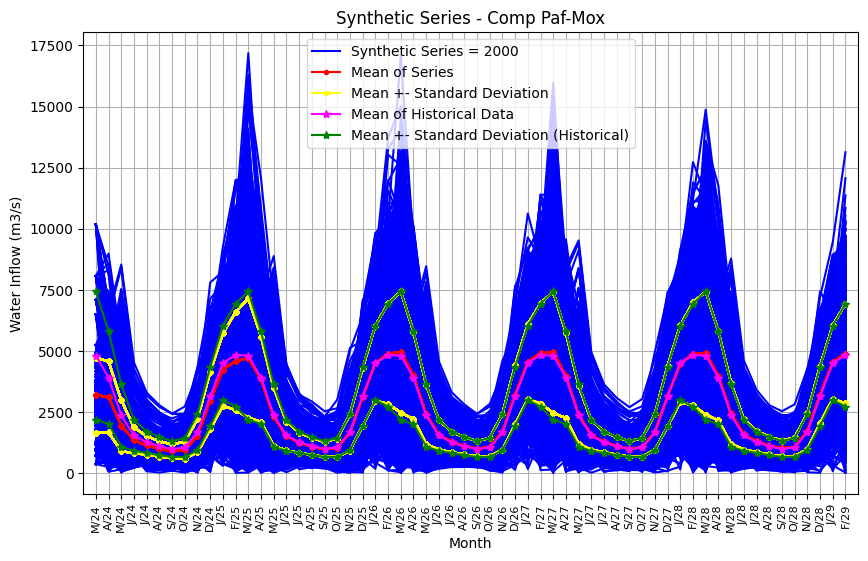

In [ ]:
series_3 = series_sinteticas(Nome_usina='Comp Paf-Mox',Melhor_ordem=Melhor_ordem,Ano_inicial_horizonte=2024,Mes_inicial='Março',Mes_final='Dezembro',Horizonte=5,Nr_series=2000,Ano_Atual=2024,grafico=True)